In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import ipdb


print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [7]:
class KITTIDataset(Dataset):
    def __init__(self, pointcloud_dir, labels_dir):
        """
        Args:
            root_dir (string): Directory with all the point clouds.
        """
        self.pointcloud_dir = pointcloud_dir
        self.pointcloud_files = [f for f in os.listdir(self.pointcloud_dir) if
                                  os.path.isfile(os.path.join(self.pointcloud_dir, f))]
        self.labels_dir = labels_dir
        self.labels_files = [f for f in os.listdir(self.labels_dir) if 
                             os.path.isfile(os.path.join(self.labels_dir, f))]
        

    def __len__(self):
        return len(self.self.pointcloud_files)
    

    def __getitem__(self, idx):
        # Retrieve pointcloud:
        point_cloud_path = os.path.join(self.pointcloud_dir, self.pointcloud_files[idx])
        point_cloud = self.load_point_cloud_from_bin(point_cloud_path)

        # Retrieve label:
        label_file = self.pointcloud_files[idx]
        label_file = label_file[:-3] + 'txt'
        label_path = os.path.join(self.labels_dir, label_file)
        labels = self.parse_kitti_label_file(label_path)
        return point_cloud, labels
    
    
    def load_point_cloud_from_bin(self, bin_path):
        print(f'File loaded: {bin_path}')
        with open(bin_path, 'rb') as f:
            content = f.read()
            point_cloud = np.frombuffer(content, dtype=np.float32)
            point_cloud = point_cloud.reshape(-1, 4)  # KITTI point clouds are (x, y, z, intensity)
        return torch.from_numpy(point_cloud)
    
    
    def parse_kitti_label_file(self, label_path):

        labels = {'Car': [], 'DontCare': []}  # Initialize a dictionary for 'Car' and 'DontCare' classes.

        # Pre-allocate labels list:
        label_size = 15 # FIXME: Don-t hardcode me
        labels_list = []
        for i in range(15):
            labels_list.append('NA')
    
        with open(label_path, 'r') as file:
            current_line_num = 0

            for line in file:
                parts = line.split()
                label_type = parts[0]
                if label_type in ['Car', 'Dont Care']:  # Here more classes can be added
                    truncated = float(parts[1])
                    occluded = int(parts[2])
                    alpha = float(parts[3])
                    bbox = [float(x) for x in parts[4:8]]
                    dimensions = [float(x) for x in parts[8:11]]
                    location = [float(x) for x in parts[11:14]]
                    rotation_y = float(parts[14])
                    # Optionally handle the score if it exists.
                    score = float(parts[15]) if len(parts) > 15 else None
                        

                    annotation = {
                        'truncated': truncated,
                        'occluded': occluded,
                        'alpha': alpha,
                        'bbox': bbox,
                        'dimensions': dimensions,
                        'location': location,
                        'rotation_y': rotation_y,
                        'score': score
                    }

                    # TODO: Use len(line) to know how many elements to pad in the dictionary key of type list
                    
                    '''for i in range(len(labels_list)): # FIXME: FINISH THIS LOGIC # DEPRECATED???
                        if (labels_list[i] == 'NA'):
                            labels_list[i] = annotation
                            break'''
                    
                    labels[label_type].append(annotation)
                    current_line_num += 1

        print(labels)
        return labels

      

train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
#train_full_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne' # FIXME: Comment
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'


test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# TODO: Add Loader for test set (No labels)

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin
{'Car': [{'truncated': 0.3, 'occluded': 3, 'alpha': 0.62, 'bbox': [0.0, 180.58, 305.09, 333.32], 'dimensions': [1.52, 1.69, 3.68], 'location': [-5.68, 1.62, 8.12], 'rotation_y': 0.03, 'score': None}, {'truncated': 0.0, 'occluded': 2, 'alpha': -2.58, 'bbox': [18.95, 182.56, 305.16, 292.4], 'dimensions': [1.45, 1.55, 3.21], 'location': [-6.43, 1.61, 10.5], 'rotation_y': -3.12, 'score': None}, {'truncated': 0.0, 'occluded': 1, 'alpha': -2.74, 'bbox': [245.18, 174.2, 401.84, 242.51], 'dimensions': [1.57, 1.47, 3.23], 'location': [-6.97, 1.63, 17.63], 'rotation_y': -3.12, 'score': None}, {'truncated': 0.0, 'occluded': 2, 'alpha': -2.82, 'bbox': [286.23, 179.08, 433.18, 235.19], 'dimensions': [1.43, 1.57, 3.46], 'location': [-6.78, 1.62, 19.66], 'rotation_y': 3.14, 'score': None}, {'truncated': 0.0, 'occluded': 0, 'alpha': -2.31, 'bbox': [730.21, 176.0, 828.5,

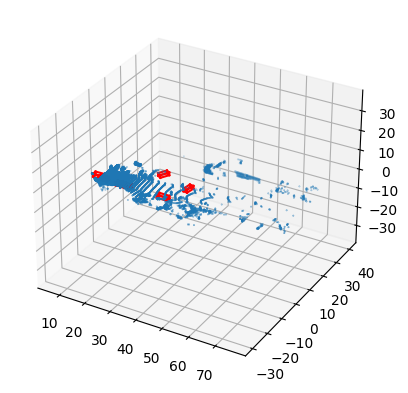

In [8]:
# Visualize some point clouds with its bounding boxes:
# Note: This is just for visualization purposes


def draw_box(ax, vertices, color='r'):
    # Define the order of the vertices for the lines to draw the edges of the 3D bounding box
    lines = [
        [vertices[i], vertices[j]] for i, j in [
            (0, 1), (1, 2), (2, 3), (3, 0),  # lower edges
            (4, 5), (5, 6), (6, 7), (7, 4),  # upper edges
            (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
        ]
    ]
    # Plot the lines
    for line in lines:
        ax.plot3D(*zip(*line), color=color)


def plot_point_cloud_with_bboxes(point_cloud, annotations):
    # Assuming 'point_cloud' is a NumPy array of shape (-1, 4)
    # 'annotations' is a list of dictionaries with 'bbox', 'dimensions', 'location', 'rotation_y'

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the point cloud
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.1)

    # For each car annotation, draw the bounding box
    for annotation in annotations.get('Car', []):
        h, w, l = annotation['dimensions']
        y, z, x = annotation['location'] # TODO: Verify if it is x, y, z or order is wrong
        ry = annotation['rotation_y']


        # Create a bounding box in the vehicle's reference frame
        corners = np.array([
            [l / 2, w / 2, 0],
            [-l / 2, w / 2, 0],
            [-l / 2, -w / 2, 0],
            [l / 2, -w / 2, 0],
            [l / 2, w / 2, h],
            [-l / 2, w / 2, h],
            [-l / 2, -w / 2, h],
            [l / 2, -w / 2, h],
        ])

        # Rotate the bounding box
        rotation_matrix = np.array([
            [np.cos(ry), -np.sin(ry), 0],
            [np.sin(ry), np.cos(ry), 0],
            [0, 0, 1]
        ])
        corners_rotated = np.dot(corners, rotation_matrix.T)

        # Translate the bounding box
        corners_rotated += np.array([x, y, z])

        # Draw the bounding box
        draw_box(ax=ax, vertices=corners_rotated)

    # Set axes limits
    max_range = np.array([point_cloud[:, 0].max() - point_cloud[:, 0].min(),
                          point_cloud[:, 1].max() - point_cloud[:, 1].min(),
                          point_cloud[:, 2].max() - point_cloud[:, 2].min()]).max() / 2.0

    mid_x = (point_cloud[:, 0].max() + point_cloud[:, 0].min()) * 0.5
    mid_y = (point_cloud[:, 1].max() + point_cloud[:, 1].min()) * 0.5
    mid_z = (point_cloud[:, 2].max() + point_cloud[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

# Example usage:
point_cloud, labels = train_set[0]  # Replace 0 with the index of the point cloud you want to visualize
plot_point_cloud_with_bboxes(point_cloud.numpy(), labels)



How are we getting labels?

In [7]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')

class PillarFeatureNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PillarFeatureNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        
        self.to(device)

    
    def forward(self, x):
        # Input x is of shape (D, P, N)
        # Convert it to (P, D, N) for 1x1 convolution      
        x = x.to(device)
        x = x.permute(1, 0, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Max pooling operation over the points' dimension
        x, _ = torch.max(x, dim=2)  # Output shape: (P, C)
        return x.T  # Output shape: (C, P)




class Pillarization:
    def __init__(self, x_min, x_max, y_min, y_max, z_min, z_max, pillar_size, max_points_per_pillar, aug_dim):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.z_min = z_min
        self.z_max = z_max
        self.pillar_size = pillar_size
        self.max_points_per_pillar = max_points_per_pillar
        self.aug_dim = aug_dim
        self.num_x_pillars = int((self.x_max - self.x_min) / self.pillar_size[0])
        self.num_y_pillars = int((self.y_max - self.y_min) / self.pillar_size[1])
        

    def make_pillars(self, points):
        """
        Convert point cloud (x, y, z) into pillars.
        """
        # Mask points outside of our defined boundaries
        
        mask = (
            (points[:, 0] >= self.x_min) & (points[:, 0] <= self.x_max) &
            (points[:, 1] >= self.y_min) & (points[:, 1] <= self.y_max) &
            (points[:, 2] >= self.z_min) & (points[:, 2] <= self.z_max)
        )
        points = points[mask]

        
        # Using numpy's digitize to find the interval/bin each point belongs to.
        self.x_indices = torch.tensor(np.digitize(points[:, 0],
            np.linspace(self.x_min, self.x_max, self.num_x_pillars))) - 1
        
        self.y_indices = torch.tensor(np.digitize(points[:, 1], 
            np.linspace(self.y_min, self.y_max, self.num_y_pillars))) - 1
        
        pillars = torch.zeros((self.num_x_pillars, self.num_y_pillars, self.max_points_per_pillar, 
            self.aug_dim))
        
        # Count how many points are in each pillar to ensure we don't exceed `max_points_per_pillar`
        count = torch.zeros((self.num_x_pillars, self.num_y_pillars), dtype=torch.long)
        
        if (device != torch.device('cpu')):
            self.x_indices.to(device)
            self.y_indices.to(device)
            points = points.to(device)
            pillars = pillars.to(device)
            count = count.to(device)
           
        # Calculate pillar x-y center:
        pillar_x_center = self.x_indices * self.pillar_size[0] + self.pillar_size[0] / 2.0
        pillar_y_center = self.y_indices * self.pillar_size[1] + self.pillar_size[1] / 2.0 

        
        # TODO: Store points in the pillars in a vectorized way filling the pillars tensor:        
        for i in range(points.shape[0]):
            x_ind = self.x_indices[i]
            y_ind = self.y_indices[i]
            
            if count[x_ind, y_ind] < self.max_points_per_pillar:
                # Compute x_c, y_c and z_c
                x_c = (x_ind * self.pillar_size[0] + self.pillar_size[0] / 2.0) - points[i, 0]
                y_c = (y_ind * self.pillar_size[1] + self.pillar_size[1] / 2.0) - points[i, 1]
                z_c = (self.z_min + self.z_max) / 2 - points[i, 2] # assuming the z-center is the midpoint
                
                # Calculate pillar center
                x_pillar_center = (x_ind * self.pillar_size[0] + self.pillar_size[0] / 2.0)
                y_pillar_center = (y_ind * self.pillar_size[1] + self.pillar_size[1] / 2.0)
                
                # Add original x, y, and z coordinates, then x_c, y_c, z_c
                pillars[x_ind, y_ind, count[x_ind, y_ind], :3] = points[i, :3]
                
                if (device != torch.device('cpu')): 
                    pillars[x_ind, y_ind, count[x_ind, y_ind], 3:6] = torch.tensor([x_c, y_c, z_c]).to(device)
                else: 
                    pillars[x_ind, y_ind, count[x_ind, y_ind], 3:6] = torch.tensor([x_c, y_c, z_c])
                    
                pillars[x_ind, y_ind, count[x_ind, y_ind], 6] = x_pillar_center - pillars[x_ind, y_ind, count[x_ind, y_ind], 0]
                pillars[x_ind, y_ind, count[x_ind, y_ind], 7] = y_pillar_center - pillars[x_ind, y_ind, count[x_ind, y_ind], 1]
                
                count[x_ind, y_ind] += 1
                
        
        # Zero-padding if too few point, random sampling if too many points:
        for i in range(self.num_x_pillars):
            for j in range(self.num_y_pillars):
                if pillars[i, j].shape[0] > self.max_points_per_pillar:
                    # Randomly sample points if there are too many for a given pillar
                    pillars[i, j] = pillars[i, j][torch.randperm(pillars[i, j].shape[0])[:self.max_points_per_pillar]]
                elif pillars[i, j].shape[0] < self.max_points_per_pillar:
                    # Zero pad if there are too few points for a given pillar
                    pillars[i, j] = torch.cat((pillars[i, j], torch.zeros((self.max_points_per_pillar - 
                                                                           pillars[i, j].shape[0], pillars[i, j].shape[1]))))
        
        # Reshape pillars to size (D,P,N):
        pillars = pillars.permute(3, 0, 1, 2).reshape(D, -1, N)
        
        return pillars


class PseudoImageDataset(Dataset):
    def __init__(self, pointcloud_dir, D, N, transform=None):
        self.pointcloud_dir = pointcloud_dir
        self.filenames = [f for f in os.listdir(self.pointcloud_dir) if os.path.isfile(os.path.join(self.pointcloud_dir, f))]
        self.transform = transform
        
        self.pillarizer = Pillarization(aug_dim=D, x_min=-40.0, x_max=40.0, y_min=-25.0, y_max=25.0, 
                                        z_min=-3, z_max=3, pillar_size=(0.5, 0.5), max_points_per_pillar=N)
        self.feature_extractor = PillarFeatureNet(D, 64)  # TODO: Don't hardcode me

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        point_cloud, label = train_set[idx] #.load_point_cloud_from_bin(os.path.join(self.pointcloud_dir, self.filenames[idx]))
        pillars = self.pillarizer.make_pillars(point_cloud)
        
        # Apply linear activation, batchnorm, and ReLU for feature extraction from pillars tensor
        features = self.feature_extractor(pillars)
        
        # Generate pseudo-image (GPU)
        pseudo_image = torch.zeros(features.shape[0], self.pillarizer.num_y_pillars, self.pillarizer.num_x_pillars).to(device)
        
        # Scatter the features back to their original pillar locations
        print(f'Loading point cloud number {idx}')
        for i in range(features.shape[1]):
            x_ind = self.pillarizer.x_indices[i].long() # SUS: Is the indexing here correct?
            y_ind = self.pillarizer.y_indices[i].long()
            pseudo_image[:, y_ind, x_ind] = features[:, i]

        
        if self.transform:
            pseudo_image = self.transform(pseudo_image)
            
        return pseudo_image, label
        
        
# Create the dataset and DataLoader
D = 9
N = 100
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir , D=D, N=N)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [9]:
device

device(type='cpu')

Now, get batches of data:

In [10]:
for batch_idx, (pseudo_image, label) in enumerate(train_loader):
    print(pseudo_image)
    break



File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006881.bin


KeyError: 0

In [ ]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

In [5]:

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, L, stride):
        super(Block, self).__init__()
        layers = []
        # First layer with the specified stride
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        layers.append(nn.BatchNorm2d(out_channels)) # TODO -> Uncomment and batch
        layers.append(nn.ReLU(inplace=True))
        
        # Subsequent layers with stride 1
        for _ in range(1, L):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, stride, output_padding):
        super(UpSample, self).__init__()
        # Assuming stride_out is always half of stride_in based on the diagram
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, output_padding=output_padding),
            nn.BatchNorm2d(out_channels), # TODO> Uncomment and batch
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.up(x)

class BackBone(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BackBone, self).__init__()

        # Define blocks with arbitrary L for now (can be tuned based on requirements)
        self.block1 = Block(in_channels, out_channels*2, L=3, stride=1)
        self.block2 = Block(out_channels*2, out_channels*2, L=3, stride=2)
        self.block3 = Block(out_channels*2, out_channels*2, L=3, stride=2)
        

        # Define upsampling layers        
        self.up1 = UpSample(out_channels*2, out_channels*2, stride=1, output_padding=0)
        self.up2 = UpSample(out_channels*2, out_channels*2, stride=2, output_padding=1)
        self.up3 = UpSample(out_channels*2, out_channels*2, stride=4, output_padding=3)
        
    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x2.size()
        # Upsample and concatenate
        up_x1 = self.up1(x1)   
        up_x2 = self.up2(x2)
        up_x3 = self.up3(x3)     
        concat_features = torch.cat([up_x1, up_x2, up_x3], dim=1)
        
        return concat_features

    
backbone = BackBone(in_channels=64, out_channels=64)
backbone_features = backbone(pseudo_image)

In [6]:
backbone_features.size()




torch.Size([4, 384, 100, 160])

Now, implement the Detection Head:

In [7]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, grid_size_x, grid_size_y, num_anchors, num_classes):
        super(DetectionHead, self).__init__()
        self.grid_size_x = grid_size_x
        self.grid_size_y = grid_size_y
        self.num_anchors = num_anchors
        self.num_classes = num_classes

        # Assuming 4 anchor boxes per cell
        self.loc_layer = nn.Conv2d(in_channels, num_anchors * 3, 1)
        self.size_layer = nn.Conv2d(in_channels, num_anchors * 3, 1)
        self.clf_layer = nn.Conv2d(in_channels, num_anchors * (num_classes + 1), 1) # +1 for confidence score
        self.occupancy_layer = nn.Conv2d(in_channels, num_anchors * 1, 1)
        self.angle_layer = nn.Conv2d(in_channels, num_anchors * 1, 1)
        self.heading_layer = nn.Conv2d(in_channels, num_anchors * 1, 1)

    def forward(self, x):
        loc = self.loc_layer(x).view(x.size(0), self.num_anchors, 3, self.grid_size_x, self.grid_size_y)
        size = self.size_layer(x).view(x.size(0), self.num_anchors, 3, self.grid_size_x, self.grid_size_y)
        clf = self.clf_layer(x).view(x.size(0), self.num_anchors, self.num_classes + 1, self.grid_size_x, self.grid_size_y)
        occupancy = self.occupancy_layer(x).view(x.size(0), self.num_anchors, 1, self.grid_size_x, self.grid_size_y)
        angle = self.angle_layer(x).view(x.size(0), self.num_anchors, 1, self.grid_size_x, self.grid_size_y)
        heading = self.heading_layer(x).view(x.size(0), self.num_anchors, 1, self.grid_size_x, self.grid_size_y)

        # Adjust the shape to match the output as per the provided image. 
        #loc = loc.permute(0, 3, 4, 1, 2)
        #size = size.permute(0, 3, 4, 1, 2)
        #clf = clf.permute(0, 3, 4, 1, 2)
        #occupancy = occupancy.permute(0, 3, 4, 1, 2)
        #angle = angle.permute(0, 3, 4, 1, 2)
        #heading = heading.permute(0, 3, 4, 1, 2)

        return loc, size, clf, occupancy, angle, heading


#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(backbone_features.size()[1], backbone_features.size()[2], 
                        backbone_features.size()[3], num_anchors=1, num_classes=2) # Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

In [11]:
loc.size()

torch.Size([4, 1, 3, 100, 160])

In [15]:
loc[0,:,:,:,:]

tensor([[[[-0.0429, -0.0443, -0.0088,  ...,  0.0088, -0.0071, -0.0120],
          [ 0.0092, -0.1676,  0.0165,  ..., -0.0987, -0.0149, -0.0155],
          [-0.0227, -0.0605, -0.0418,  ..., -0.0590, -0.0411, -0.0273],
          ...,
          [-0.0327, -0.1672, -0.0510,  ..., -0.0833, -0.0099, -0.0402],
          [-0.0260, -0.0372, -0.0325,  ..., -0.0378, -0.0255, -0.0422],
          [-0.0490, -0.0897, -0.0574,  ..., -0.0790, -0.0282, -0.0280]],

         [[-0.1106,  0.0586, -0.0007,  ...,  0.0246,  0.0050,  0.0606],
          [-0.0108, -0.0386,  0.0002,  ..., -0.0153,  0.0149,  0.0180],
          [-0.0167,  0.0717, -0.0153,  ...,  0.0562, -0.0230,  0.0447],
          ...,
          [ 0.0021, -0.0744,  0.0250,  ..., -0.0310,  0.0309, -0.0089],
          [ 0.0029,  0.0765,  0.0075,  ...,  0.0653, -0.0212,  0.0456],
          [ 0.0725, -0.0052,  0.0326,  ...,  0.0029,  0.0207,  0.0124]],

         [[ 0.0831,  0.0483,  0.0100,  ...,  0.0428,  0.0171, -0.0227],
          [ 0.0520,  0.0444, -